# Projet 7 - Implémentez un modèle de scoring


# Contexte

### Entreprise: "Prêt à Dépenser"

**Description**: Propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

**Objectif**: Créer un "scoring crédit" pour calculer la probabilité qu’un client rembourse son crédit, puis classer la demande en crédit accordé ou refusé.

**Transparence**: La transparence est essentielle, répondant à la fois aux souhaits des clients et aux valeurs de l'entreprise.

**Dashboard interactif**:
- Fournit une explication claire et transparente des décisions d’octroi de crédit.
- Permet aux clients d'accéder et d'explorer facilement leurs informations personnelles.


## Objectifs 

1. Construire un **modèle de scoring** qui donnera une **prédiction (classification)** sur la **probabilité de faillite** d'un client de façon **automatique**.

2. Construire un **dashboard interactif** permettant d'**interpréter les prédictions** faites par le modèle, et d’**améliorer la connaissance client**.

3. **Mettre en production** le modèle de scoring de prédiction à l’aide d’une **API**, ainsi que le **dashboard interactif qui appelle l’API** pour les prédictions.


## Spécifications du dashbord

- Visualiser le score et l’interprétation de ce score pour chaque client de façon clair et simple
- Visualiser des informations descriptives relatives à un client (via un système de filtre)
- Comparer les informations descriptives d'un client à un groupe de clients similaires

## Partie technique

http://ec2-35-181-155-27.eu-west-3.compute.amazonaws.com:8501/

- Librairie **evidently** pour détecter du **Data Drift** en production 
    - **Hypothèse:** “application_train” = datas pour la modélisation ET “application_test” = datas de nouveaux clients 
    - Créer un tableau HTML pour illustrer ce data drift

- **Déploiement de l'application dashboard et de l’API:** Plateforme Cloud (gratuit), AWE a été selectionné

- Effectuer de la **Cross-Validation**

- Si les **scores scores AUC sont supérieurs à 0.82**, le modèle possède probablement de l’**overfitting** 

- Création d'une **note technique:** Présentera l’élaboration du modèle jusqu’à l’analyse du Data Drift

## Conseils sur l'elaboration du modèle

- Prendre en compte le **déséquilibre entre le nombre de bons et de moins bons clients** (utiliser une méthode au choix) 
- Prendre en compte le déséquilibre du **coût métier** entre entre un **faux négatif** et un **faux positif**:
    - **Faux négatif:** mauvais client prédit bon client : donc crédit accordé et perte en capital
    - **Faux positif:** Bon client prédit mauvais : donc refus crédit et manque à gagner en marge
    - Hypothèse: le coût d’un FN est **dix fois supérieur** au coût d’un FP
    
- **Création d'un score "métier":** Minimisation du coût d’erreur de prédiction des FN et FP
    - Ce score permet de choisir le **meilleur modèle** et ses **meilleurs hyperparamètres**
    
- Utiliser aussi l'**ACU** et l'**accuracy** pour affiner notre modèle et ses hyperparamètres

## Livrable

- Application de dashboard interactif + l’API de prédiction du score, déployées chacunes sur le cloud.
- **Un dossier, géré via un outil de versioning** de code contenant:
    - **Notebook de la modélisation** (du prétraitement à la prédiction), intégrant via MLFlow le tracking d’expérimentations et le stockage centralisé des modèles
    - **Le code** générant le dashboard
    - **Le code** permettant de déployer le modèle sous forme d'API
    - **Un fichier** permettant de comprendre l'objectif du projet et le découpage des dossiers
    - **Un fichier** listant les packages utilisés 
    - **Tableau HTML** d’analyse de data drift réalisé à partir d’evidently
- Une **note méthodologique** (PDF?) décrivant:
    - La méthodologie d'entraînement du modèle (2 pages maximum)
    - Le traitement du déséquilibre des classes (1 page maximum)
    - La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
    - Un tableau de synthèse des résultats (1 page maximum)
    - L’interprétabilité globale et locale du modèle (1 page maximum)
    - Les limites et les améliorations possibles (1 page maximum)
    - L’analyse du Data Drift (1 page maximum)
- Un **support de présentation pour la soutenance** (Powerpoint)
    - Copies écran des commits, du dossier Github (+ lien vers ce dossier) et de l’exécution des tests unitaires
        - Ce sont les preuves qu’un pipeline de déploiement continu a permis de déployer l’API, doivent être formalisés dans ce support de présentation

## Analyse de nos csv

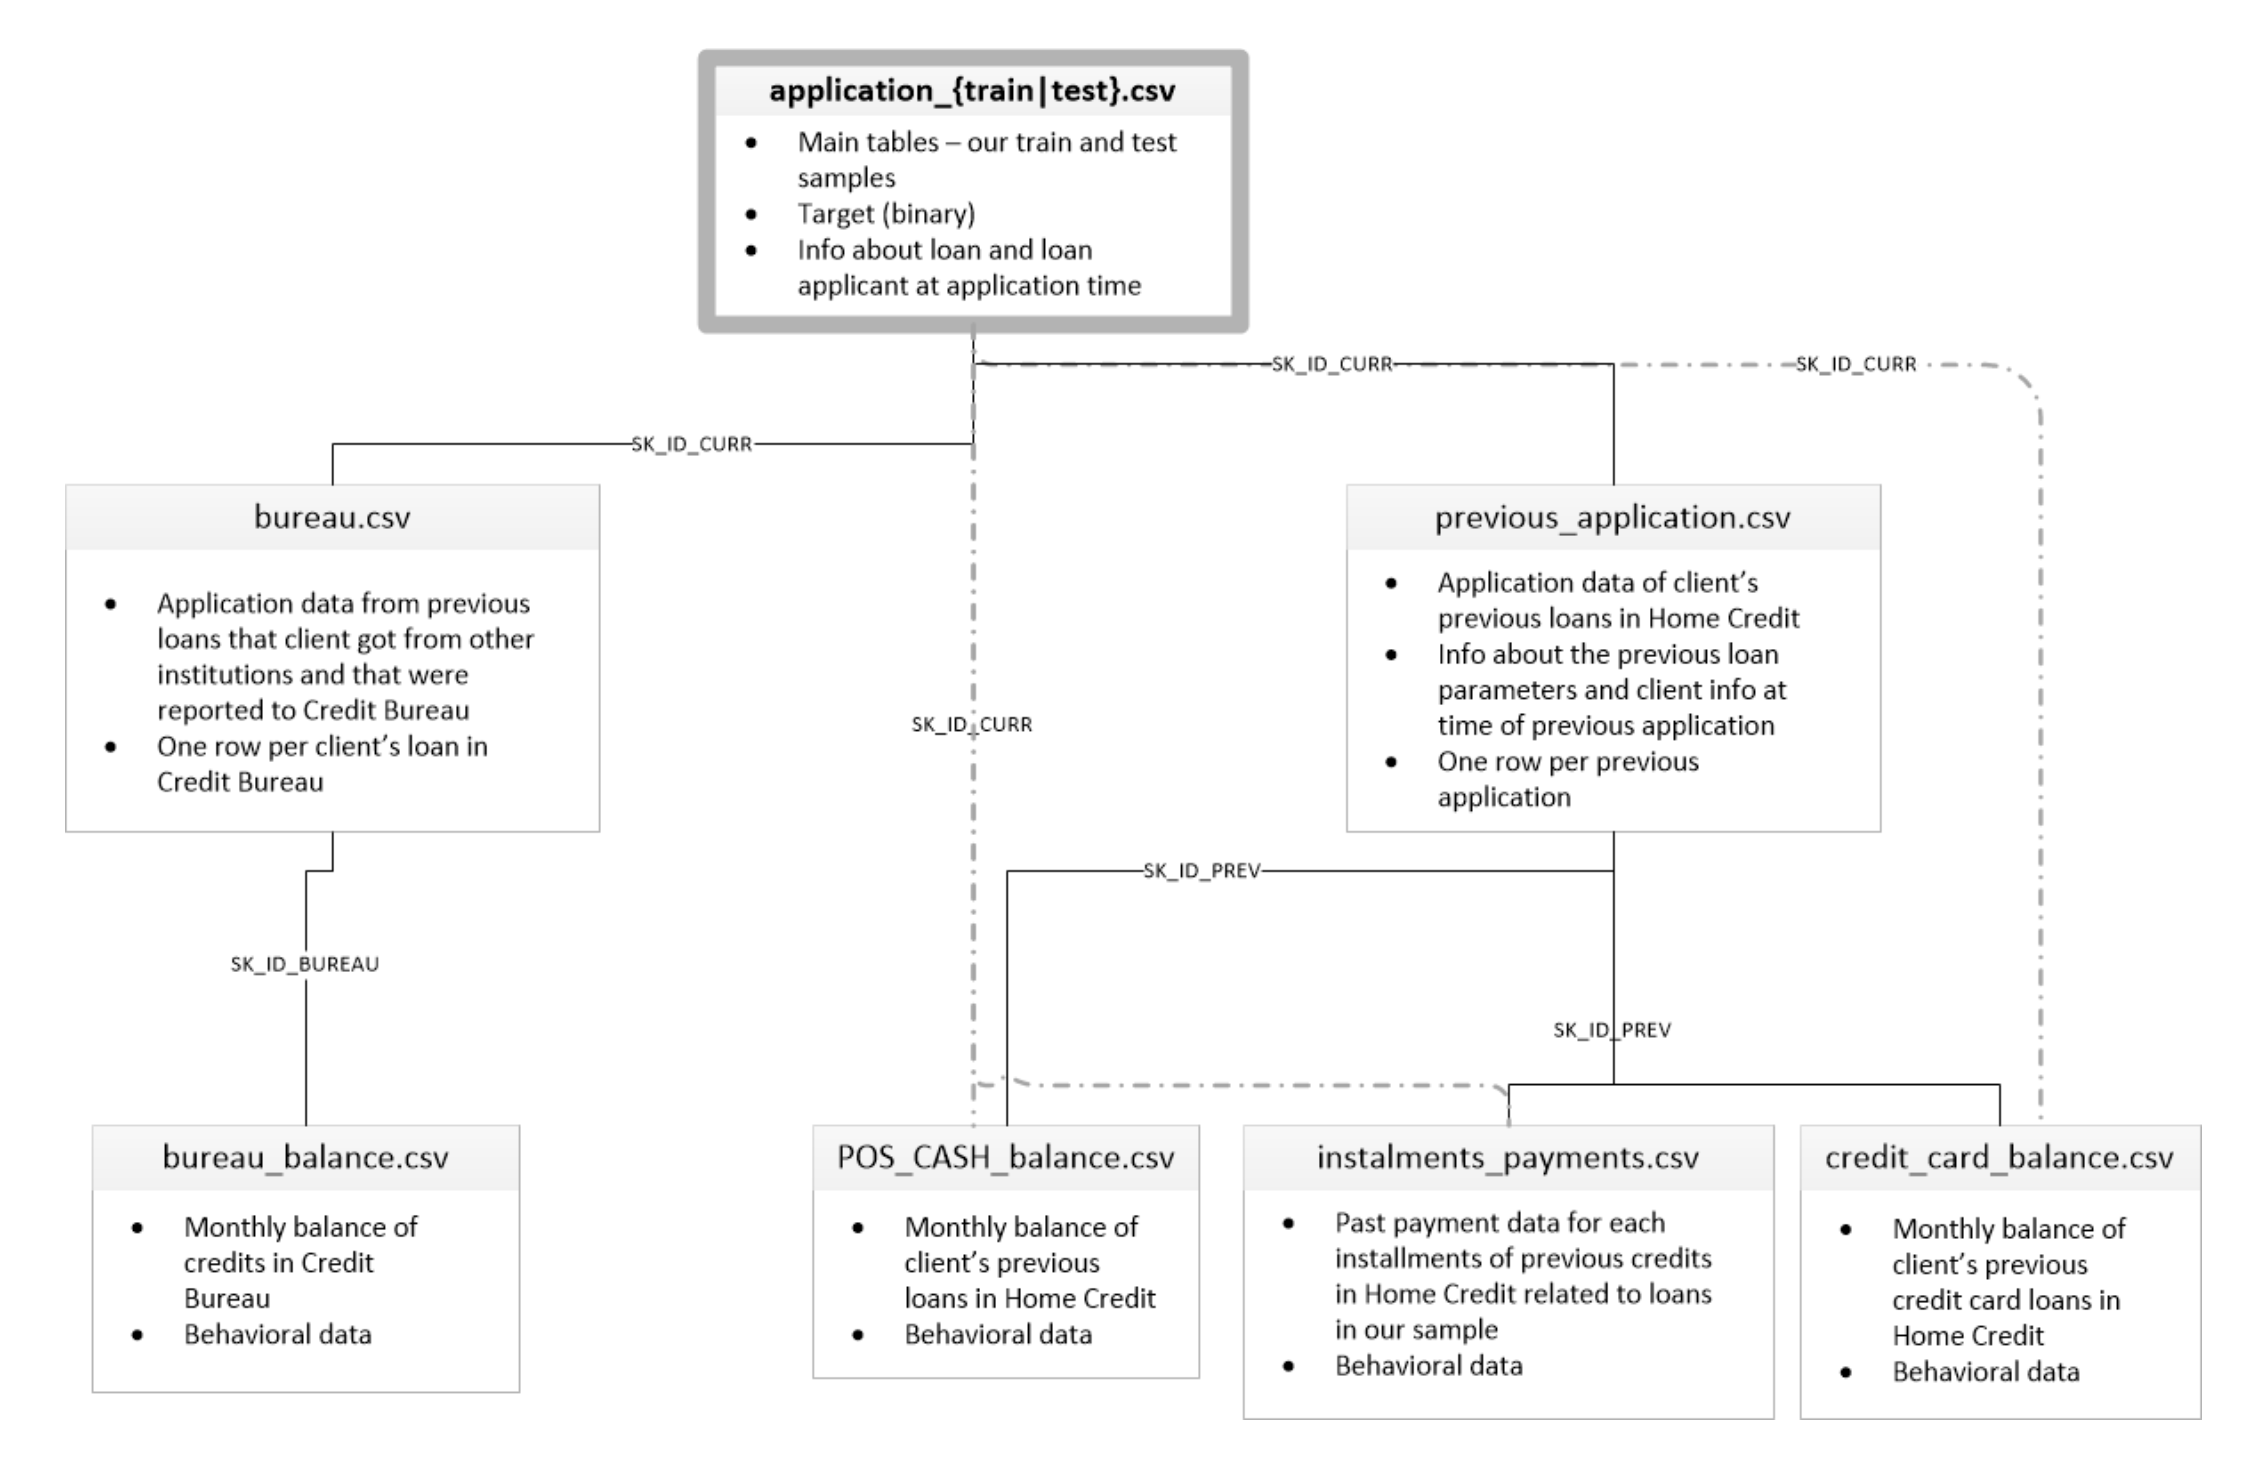

# Imports et fonctions

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Création du tableau

## Définition de chaque colonnes

In [4]:
definition_colonnes = pd.read_csv('input\HomeCredit_columns_description.csv', encoding='ISO-8859-1')

In [5]:
definition_colonnes.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                                                                                                                                                                   Description  \
0                                                                                                                                                                     ID of loan in our sample   
1  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2                                                                                                                                                  Identification if loan is cash or revolving   
3                                                                                                                                                                         Gender of the client   
4                                                                                                                                                                Flag if the client owns a car   

  Special  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

## application_train/test

**On importe le csv application_train**

In [6]:
df = pd.read_csv('input/application_train.csv')
# input\application_train.csv

In [7]:
print(df.shape)
df.head()

(307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

**On importe le csv application_test**

In [8]:
test_df = pd.read_csv('input/application_test.csv')

In [9]:
print(test_df.shape)
test_df.head()

(48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

**On va fusionner les csv train + test**

In [10]:
df = pd.concat([df, test_df], ignore_index=True)

In [11]:
print(df.shape)

(356255, 122)


**On va supprimer la colonne "test_df" qui nous sert plus a rien**

In [12]:
del test_df

**On supprime les lignes ou on ne connait pas le sexe de la personne**

In [13]:
df = df[df['CODE_GENDER'] != 'XNA']

In [14]:
print(df.shape)

(356251, 122)


**On pratique le one_hot_encoder sur nos colonnes catégorielles**

In [15]:
df, cat_cols = one_hot_encoder(df, nan_as_category = False)

In [16]:
print(df.shape)

(356251, 245)


**On suprimme des valeurs abérantes de la colonne "DAYS_EMPLOYED"**

In [17]:
definition_colonnes[definition_colonnes["Row"] == "DAYS_EMPLOYED"]

Unnamed: 0                         Table            Row  \
18          21  application_{train|test}.csv  DAYS_EMPLOYED   

                                                                   Description  \
18  How many days before the application the person started current employment   

                                  Special  
18  time only relative to the application

In [18]:
df[df['DAYS_EMPLOYED'] == 365243].shape

(64648, 245)

On a ~64000 lignes ou ce nombre de jours présente une valeur aberrante

In [19]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

**Création de nouvelles features**

**DAYS_EMPLOYED_PERC:**
- Pourcentage de la vie d'une personne qu'elle a passé à travailler.

In [20]:
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
print(df.shape)

(356251, 246)


**INCOME_CREDIT_PERC:**
- Rapport entre le revenu total d'une personne et le montant total du crédit qu'elle a reçu.

In [21]:
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
print(df.shape)

(356251, 247)


**INCOME_PER_PERSON:**
- Revenu moyen par membre de la famille.

In [22]:
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
print(df.shape)

(356251, 248)


**ANNUITY_INCOME_PERC:**
- Rapport entre le montant de l'annuité (paiements périodiques) et le revenu total d'une personne.

In [23]:
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
print(df.shape)

(356251, 249)


**PAYMENT_RATE:**
- Proportion du crédit qui est remboursée annuellement.

In [24]:
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
print(df.shape)

(356251, 250)


## bureau et bureau_balance

In [25]:
bureau = pd.read_csv('input/bureau.csv')
bb = pd.read_csv('input/bureau_balance.csv')

In [26]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [27]:
bb.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [28]:
print(bureau.shape)
print(bb.shape)

(1716428, 17)
(27299925, 3)


**On procède au one_hot_encoding sur ces 2 dataframes**

In [29]:
bb, bb_cat = one_hot_encoder(bb, nan_as_category = True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category = True)

In [30]:
print(bureau.shape)
print(bb.shape)

(1716428, 40)
(27299925, 11)


In [31]:
bb.head()

SK_ID_BUREAU  MONTHS_BALANCE  STATUS_0  STATUS_1  STATUS_2  STATUS_3  \
0       5715448               0     False     False     False     False   
1       5715448              -1     False     False     False     False   
2       5715448              -2     False     False     False     False   
3       5715448              -3     False     False     False     False   
4       5715448              -4     False     False     False     False   

   STATUS_4  STATUS_5  STATUS_C  STATUS_X  STATUS_nan  
0     False     False      True     False       False  
1     False     False      True     False       False  
2     False     False      True     False       False  
3     False     False      True     False       False  
4     False     False      True     False       False

**On effectue la stratégie suivante sur les colonnes de bureau_balance**

In [32]:
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']

In [33]:
bb_aggregations

{'MONTHS_BALANCE': ['min', 'max', 'size'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_2': ['mean'],
 'STATUS_3': ['mean'],
 'STATUS_4': ['mean'],
 'STATUS_5': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean'],
 'STATUS_nan': ['mean']}

**On applique l'aggregation de bb en créant bb_agg**

In [34]:
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

In [35]:
bb_agg.head()

MONTHS_BALANCE_MIN  MONTHS_BALANCE_MAX  MONTHS_BALANCE_SIZE  \
SK_ID_BUREAU                                                                
5001709                      -96                   0                   97   
5001710                      -82                   0                   83   
5001711                       -3                   0                    4   
5001712                      -18                   0                   19   
5001713                      -21                   0                   22   

              STATUS_0_MEAN  STATUS_1_MEAN  STATUS_2_MEAN  STATUS_3_MEAN  \
SK_ID_BUREAU                                                               
5001709            0.000000            0.0            0.0            0.0   
5001710            0.060241            0.0            0.0            0.0   
5001711            0.750000            0.0            0.0            0.0   
5001712            0.526316            0.0            0.0            0.0   
5001713            0.000000            0.0            0.0            0.0   

              STATUS_4_MEAN  STATUS_5_MEAN  STATUS_C_MEAN  STATUS_X_MEAN  \
SK_ID_BUREAU                                                               
5001709                 0.0            0.0       0.886598       0.113402   
5001710                 0.0            0.0       0.578313       0.361446   
5001711                 0.0            0.0       0.000000       0.250000   
5001712                 0.0            0.0       0.473684       0.000000   
5001713                 0.0            0.0       0.000000       1.000000   

              STATUS_nan_MEAN  
SK_ID_BUREAU                   
5001709                   0.0  
5001710                   0.0  
5001711                   0.0  
5001712                   0.0  
5001713                   0.0

**On fusionne bureau et bureau_balance_agrégée**

In [36]:
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
bureau.shape

(1716428, 51)

**On supprime bb et bb_agg**

In [37]:
del bb, bb_agg

**Stratégies pour les variables NON catégorielles de bureau:**

In [38]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

**Stratégies pour les variables catégorielles de bureau (moyenne):**

In [39]:
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

**Aggregation des lignes de bureau (création de bureau_agg)**

In [40]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [41]:
print(bureau_agg.shape)
bureau_agg.head()

(305811, 62)


BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49            -735.000000   
100002                     -1437                  -103            -874.000000   
100003                     -2586                  -606           -1400.750000   
100004                     -1326                  -408            -867.000000   
100005                      -373                   -62            -190.666667   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   
100003             827783.583333                       -2434.0   
100004             421362.000000                        -595.0   
100005              26340.333333                        -128.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   
100003                            1216.0                    -544.500000   
100004                            -382.0                    -488.500000   
100005                            1324.0                     439.333333   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   
100003                       -816.000000                            0   
100004                       -532.000000                            0   
100005                        -54.333333                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  \
SK_ID_CURR                                                                   
100001                               0.0                               NaN   
100002                               0.0                          1681.029   
100003                               0.0                             0.000   
100004                               0.0                             0.000   
100005                               0.0                             0.000   

            BURO_AMT_CREDIT_SUM_MAX  BURO_AMT_CREDIT_SUM_MEAN  \
SK_ID_CURR                                                      
100001                     378000.0             207623.571429   
100002                     450000.0             108131.945625   
100003                     810000.0             254350.125000   
100004                      94537.8              94518.900000   
100005                     568800.0             219042.000000   

            BURO_AMT_CREDIT_SUM_SUM  BURO_AMT_CREDIT_SUM_DEBT_MAX  \
SK_ID_CURR                                                          
100001                  1453365.000                      373239.0   
100002                   865055.565                      245781.0   
100003                  1017400.500                           0.0   
100004                   189037.800                           0.0   
100005                   657126.000                      543087.0   

            BURO_AMT_CREDIT_SUM_DEBT_MEAN  BURO_AMT_CREDIT_SUM_DEBT_SUM  \
SK_ID_CURR                                                                
100001                       85240.928571                      596686.5   
100002                       49156.200000                      245781.0   
100003                           0.000000                           0.0   
100004                           0.000000                           0.0   
100005

**On va ajouter dans bureau_agg les crédits actifs uniquement**

In [42]:
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

In [43]:
bureau_agg.shape

(305811, 89)

**On fait pareil pour les crédits fermés**

In [44]:
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

In [45]:
bureau_agg.shape

(305811, 116)

## Fusion df avec bureau_agg

In [46]:
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')

In [47]:
print(df.shape)
df.head()

(356251, 366)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002     1.0             0          202500.0    406597.5   
1      100003     0.0             0          270000.0   1293502.5   
2      100004     0.0             0           67500.0    135000.0   
3      100006     0.0             0          135000.0    312682.5   
4      100007     0.0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0            -2120          NaN           1   
1        -1188.0            -1186.0             -291          NaN           1   
2         -225.0            -4260.0            -2531         26.0           1   
3        -3039.0            -9833.0            -2437          NaN           1   
4        -3038.0            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

## previous_applications

In [48]:
prev = pd.read_csv('input/previous_application.csv')

In [49]:
print(prev.shape)
prev.head()

(1670214, 37)


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

**On effectue le one_hot_encoder**

In [50]:
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

In [51]:
print(prev.shape)

(1670214, 180)


**Comme précédemment on supprime les valeurs abrérantes (ou le nb de jours = 365243 = 1000 ans)**

In [52]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

**Création d'une feature "APP_CREDIT_PERC":**


In [53]:
definition_colonnes[definition_colonnes["Row"] == "AMT_APPLICATION"]

Unnamed: 0                     Table              Row  \
177         180  previous_application.csv  AMT_APPLICATION   

                                                        Description Special  
177  For how much credit did client ask on the previous application     NaN

- Montant que le client souhaitait emprunter lorsqu'il a soumis sa demande

In [54]:
definition_colonnes[definition_colonnes["Row"] == "AMT_CREDIT"]

Unnamed: 0                         Table         Row  \
8            11  application_{train|test}.csv  AMT_CREDIT   
178         181      previous_application.csv  AMT_CREDIT   

                                                                                                                                                                                                                                                             Description  \
8                                                                                                                                                                                                                                              Credit amount of the loan   
178  Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT   

    Special  
8       NaN  
178     NaN

- Montant du crédit qui a finalement été accordé au client lors de sa demande précédente

APP_CREDIT_PERC: Donne une idée de la manière dont le montant demandé par le client se compare au montant réellement accordé 

In [55]:
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

**Voici la stratégie d'aggrégation pour les colonnes NON catégorielles:**

In [56]:
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}

**Voici la stratégie d'aggrégation pour les colonnes catégorielles (moyenne):**

In [57]:
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

**On effectue l'aggrégation sur prev (donnant prev_agg)**

In [58]:
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

In [59]:
print(prev_agg.shape)
prev_agg.head()

(338857, 189)


PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                  3951.000              3951.000               3951.000   
100002                  9251.775              9251.775               9251.775   
100003                  6737.310             98356.995              56553.990   
100004                  5357.250              5357.250               5357.250   
100005                  4813.200              4813.200               4813.200   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                       68809.5                  900000.0   
100004                       24282.0                   24282.0   
100005                           0.0                   44617.5   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                   
100001                       24835.50              23787.0   
100002                      179055.00             179055.0   
100003                      435436.50              68053.5   
100004                       24282.00              20106.0   
100005                       22308.75                  0.0   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0              23787.00   
100002                 179055.0             179055.00   
100003                1035882.0             484191.00   
100004                  20106.0              20106.00   
100005                  40153.5              20076.75   

            PREV_APP_CREDIT_PERC_MIN  PREV_APP_CREDIT_PERC_MAX  \
SK_ID_CURR                                                       
100001                      1.044079                  1.044079   
100002                      1.000000                  1.000000   
100003                      0.868825                  1.011109   
100004                      1.207699                  1.207699   
100005                      1.111173                  1.111173   

            PREV_APP_CREDIT_PERC_MEAN  PREV_APP_CREDIT_PERC_VAR  \
SK_ID_CURR                                                        
100001                       1.044079                       NaN   
100002                       1.000000                       NaN   
100003                       0.949329                  0.005324   
100004                       1.207699                       NaN   
100005                       1.111173                       NaN   

            PREV_AMT_DOWN_PAYMENT_MIN  PREV_AMT_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                         
100001                         2520.0                     2520.0   
100002                            0.0                        0.0   
100003                            0.0                     6885.0   
100004                         4860.0                     4860.0   
100005                         4464.0                     4464.0   

            PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_GOODS_PRICE_MIN  \
SK_ID_CURR                                                         
100001                          2520.0                   24835.5   
100002                             0.0                  179055.0   
100003                          3442.5                   68809.5   
100004                          4860.0                   24282.0   
100005                          4464.0                   44617.5   

            PREV_AMT_GOODS_PRICE_MAX  PREV_AMT_GOODS_PRICE_MEAN  \
SK_ID_CURR                                                        
100001                       24835.5                    24835.5   
100002                      179055.0                   179

**Rajout des colonnes "STATUS_Approved" et "STATUS_Refused" dans prev_agg**

In [60]:
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

In [61]:
prev_agg.shape

(338857, 249)

## Fusion df et prev_agg

In [62]:
df = df.join(prev_agg, how='left', on='SK_ID_CURR')

In [63]:
print(df.shape)
df.head()

(356251, 615)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002     1.0             0          202500.0    406597.5   
1      100003     0.0             0          270000.0   1293502.5   
2      100004     0.0             0           67500.0    135000.0   
3      100006     0.0             0          135000.0    312682.5   
4      100007     0.0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0            -2120          NaN           1   
1        -1188.0            -1186.0             -291          NaN           1   
2         -225.0            -4260.0            -2531         26.0           1   
3        -3039.0            -9833.0            -2437          NaN           1   
4        -3038.0            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

## POS_CASH_balance

In [64]:
pos = pd.read_csv('input/POS_CASH_balance.csv')

In [65]:
print(pos.shape)
pos.head()

(10001358, 8)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

**On effectue le one_hot_encoder**

In [66]:
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

In [67]:
pos.shape

(10001358, 17)

**Voici la stratégie d'aggrégation sur les colonnes non catégorielles**

In [68]:
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}

**Voici la stratégie d'aggrégation sur les colonnes catégorielles**

In [69]:
for cat in cat_cols:
    aggregations[cat] = ['mean']

**On effectue l'aggrégation de pos (en créant pos_agg)**

In [70]:
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

In [71]:
print(pos_agg.shape)
pos_agg.head()

(337252, 17)


POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   
100002                          -1               -10.000000   
100003                         -18               -43.785714   
100004                         -24               -25.500000   
100005                         -15               -20.000000   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   
100003                           28               0         0.000000   
100004                            4               0         0.000000   
100005                           11               0         0.000000   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   
100002                       0             0.000000   
100003                       0             0.000000   
100004                       0             0.000000   
100005                       0             0.000000   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   
100002                                  1.000000   
100003                                  0.928571   
100004                                  0.750000   
100005                                  0.818182   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   
100003                                               0.0   
100004                                               0.0   
100005                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
SK_ID_CURR                                            
100001                                     0.222222   
100002                                     0.000000   
100003                                     0.071429   
100004                                     0.250000   
100005                                     0.090909   

            POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
SK_ID_CURR                                                        
100001                                                      0.0   
100002                                                      0.0   
100003                                                      0.0   
100004                                           

**Création de la colonne "POS_COUNT" -> Compte le nb de comptes de trésorerie**

In [72]:
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

## Fusion df et pos_agg

In [73]:
df = df.join(pos_agg, how='left', on='SK_ID_CURR')

In [74]:
print(df.shape)
df.head()

(356251, 633)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002     1.0             0          202500.0    406597.5   
1      100003     0.0             0          270000.0   1293502.5   
2      100004     0.0             0           67500.0    135000.0   
3      100006     0.0             0          135000.0    312682.5   
4      100007     0.0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0            -2120          NaN           1   
1        -1188.0            -1186.0             -291          NaN           1   
2         -225.0            -4260.0            -2531         26.0           1   
3        -3039.0            -9833.0            -2437          NaN           1   
4        -3038.0            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

## installments_payments

In [75]:
ins = pd.read_csv('input/installments_payments.csv')

In [76]:
print(ins.shape)
ins.head()

(13605401, 8)


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

**On effectue le one hot encoder**

In [77]:
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

In [78]:
ins.shape

(13605401, 8)

**On va créer des colonnes supplémentaires:**
- **PAYMENT_PERC:** le pourcentage du montant payé par rapport au montant d'échéance prescrit.
- **PAYMENT_DIFF:** la différence entre le montant d'échéance prescrit et le montant réellement payé.
- **DPD:** le nombre de jours de retard de paiement.
- **DBD:** le nombre de jours d'avance du paiement.

In [79]:
definition_colonnes[definition_colonnes["Row"] == "AMT_PAYMENT"]

Unnamed: 0                      Table          Row  \
218         221  installments_payments.csv  AMT_PAYMENT   

                                                              Description  \
218  What the client actually paid on previous credit on this installment   

    Special  
218     NaN

- Montant réellement payé par le client pour une échéance donnée.

In [80]:
definition_colonnes[definition_colonnes["Row"] == "AMT_INSTALMENT"]

Unnamed: 0                      Table             Row  \
217         220  installments_payments.csv  AMT_INSTALMENT   

                                                                           Description  \
217  What was the prescribed installment amount of previous credit on this installment   

    Special  
217     NaN

- Montant d'échéance prescrit que le client devait payer pour une échéance donnée.

In [81]:
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

In [82]:
ins.shape

(13605401, 12)

**Voici les stratégies d'agglomération pour les colonnes NON catégorielles**

In [83]:
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}

**Voici la stratégie d'agglomération pour les colonnes catégorielles (moyenne)**

In [84]:
for cat in cat_cols:
    aggregations[cat] = ['mean']

**On effectue l'agglomération sur ins (en créant ins_agg)**

In [85]:
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

In [86]:
ins_agg.shape

(339587, 25)

**On cré une feature qui compte le nombre d'acomptes**

In [87]:
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

In [88]:
print(ins_agg.shape)
ins_agg.head()

(339587, 26)


INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
SK_ID_CURR                                                          
100001                                          2            11.0   
100002                                          2             0.0   
100003                                          2             0.0   
100004                                          2             0.0   
100005                                          2             1.0   

            INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
SK_ID_CURR                                                                     
100001             1.571429            11.0            36.0         8.857143   
100002             0.000000             0.0            31.0        20.421053   
100003             0.000000             0.0            14.0         7.160000   
100004             0.000000             0.0            11.0         7.666667   
100005             0.111111             1.0            37.0        23.666667   

            INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
SK_ID_CURR                                                                      
100001                62.0                      1.0                       1.0   
100002               388.0                      1.0                       1.0   
100003               179.0                      1.0                       1.0   
100004                23.0                      1.0                       1.0   
100005               213.0                      1.0                       1.0   

            INSTAL_PAYMENT_PERC_SUM  INSTAL_PAYMENT_PERC_VAR  \
SK_ID_CURR                                                     
100001                          7.0                      0.0   
100002                         19.0                      0.0   
100003                         25.0                      0.0   
100004                          3.0                      0.0   
100005                          9.0                      0.0   

            INSTAL_PAYMENT_DIFF_MAX  INSTAL_PAYMENT_DIFF_MEAN  \
SK_ID_CURR                                                      
100001                          0.0                       0.0   
100002                          0.0                       0.0   
100003                          0.0                       0.0   
100004                          0.0                       0.0   
100005                          0.0                       0.0   

            INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
SK_ID_CURR                                                     
100001                          0.0                      0.0   
100002                          0.0                      0.0   
100003                          0.0                      0.0   
100004                          0.0                      0.0   
100005                          0.0                      0.0   

            INSTAL_AMT_INSTALMENT_MAX  INSTAL_AMT_INSTALMENT_MEAN  \
SK_ID_CURR                                                          
100001                      17397.900                 5885.132143   
100002                      53093.745                11559.247105   
100003                     560835.360                64754.586000   
100004                      10573.965                 7096.155000   
100005                      17656.245                 6240.205000   

            INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
SK_ID_CURR                                                      
100001                      41195.925                3951.000   
100002                     219625.695                9251.775   
100003                    1618864.650                6662.970   
100004                      21288.465                5357.250   
100005                      56161.845                4813.200   

            INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  \
SK_ID_CURR                                

## Fusion df et ins_agg

In [89]:
import gc
gc.collect()

0

In [90]:
df = df.join(ins_agg, how='left', on='SK_ID_CURR')

In [91]:
print(df.shape)
df.head()

(356251, 659)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002     1.0             0          202500.0    406597.5   
1      100003     0.0             0          270000.0   1293502.5   
2      100004     0.0             0           67500.0    135000.0   
3      100006     0.0             0          135000.0    312682.5   
4      100007     0.0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0            -2120          NaN           1   
1        -1188.0            -1186.0             -291          NaN           1   
2         -225.0            -4260.0            -2531         26.0           1   
3        -3039.0            -9833.0            -2437          NaN           1   
4        -3038.0            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

## credit_card_balance

In [92]:
cc = pd.read_csv('input/credit_card_balance.csv')

In [93]:
print(cc.shape)
cc.head()

(3840312, 23)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

**On applique le one_hot_encoder**

In [94]:
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)

In [95]:
cc.shape

(3840312, 30)

**On supprime la colonne 'SK_ID_PREV'**

In [96]:
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)

**On applique les stratégies suivantes pour les colonnes (en créant cc_agg):**
- minimum
- maximum
- moyenne
- somme
- variance

In [97]:
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

**On cré une colonne qui va compter le nb de cartes de crédit**

In [98]:
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

In [99]:
print(cc_agg.shape)
cc_agg.head()

(103558, 141)


CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                 
100006                         -6                     -1   
100011                        -75                     -2   
100013                        -96                     -1   
100021                        -18                     -2   
100023                        -11                     -4   

            CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                  
100006                        -3.5                    -21   
100011                       -38.5                  -2849   
100013                       -48.5                  -4656   
100021                       -10.0                   -170   
100023                        -7.5                    -60   

            CC_MONTHS_BALANCE_VAR  CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  \
SK_ID_CURR                                                                  
100006                        3.5                 0.0                0.00   
100011                      462.5                 0.0           189000.00   
100013                      776.0                 0.0           161420.22   
100021                       25.5                 0.0                0.00   
100023                        6.0                 0.0                0.00   

            CC_AMT_BALANCE_MEAN  CC_AMT_BALANCE_SUM  CC_AMT_BALANCE_VAR  \
SK_ID_CURR                                                                
100006                 0.000000               0.000        0.000000e+00   
100011             54482.111149         4031676.225        4.641321e+09   
100013             18159.919219         1743352.245        1.869473e+09   
100021                 0.000000               0.000        0.000000e+00   
100023                 0.000000               0.000        0.000000e+00   

            CC_AMT_CREDIT_LIMIT_ACTUAL_MIN  CC_AMT_CREDIT_LIMIT_ACTUAL_MAX  \
SK_ID_CURR                                                                   
100006                              270000                          270000   
100011                               90000                          180000   
100013                               45000                          157500   
100021                              675000                          675000   
100023                               45000                          225000   

            CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN  CC_AMT_CREDIT_LIMIT_ACTUAL_SUM  \
SK_ID_CURR                                                                    
100006                        270000.000000                         1620000   
100011                        164189.189189                        12150000   
100013                        131718.750000                        12645000   
100021                        675000.000000                        11475000   
100023                        135000.000000                         1080000   

            CC_AMT_CREDIT_LIMIT_ACTUAL_VAR  CC_AMT_DRAWINGS_ATM_CURRENT_MIN  \
SK_ID_CURR                                                                    
100006                        0.000000e+00                              NaN   
100011                        1.189060e+09                              0.0   
100013                        2.259252e+09                              0.0   
100021                        0.000000e+00                              NaN   
100023                        9.257143e+09                              NaN   

            CC_AMT_DRAWINGS_ATM_CURRENT_MAX  CC_AMT_DRAWINGS_ATM_CURRENT_MEAN  \
SK_ID_CURR                                                                      
100006                                  NaN                               NaN   
100011                             180000.0                       2432.432432   
100013                             157500.0                       6350.000000   
100021                               

## Fusion df et cc_agg

In [100]:
df = df.join(cc_agg, how='left', on='SK_ID_CURR')

# Vérification et nétoyage

## Vérification des valeurs infinies

Infinies positifs:

In [101]:
print((df == np.inf).sum().sum())  

61


Infinies négatifs:

In [102]:
print((df == -np.inf).sum().sum())

0


In [103]:
# Remplacer les valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Pour vérifier que les valeurs infinies ont bien été remplacées
print((df == np.inf).sum().sum())  # Cela devrait afficher 0 après le remplacement

0


## Vérification des colonnes avec une seule valeur unique (dataframe entier)

In [104]:
df.shape

(356251, 800)

In [105]:
single_value_columns = [col for col in df.columns if df[col].nunique() == 1]

print(single_value_columns)
print(len(single_value_columns))

['BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'BURO_STATUS_nan_MEAN_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR']
27


In [106]:
df.drop(columns=single_value_columns, inplace=True)

In [107]:
df.shape

(356251, 773)

In [108]:
print(df.columns)

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR',
       'CC_NAME_CONTRACT_STATUS_Signed_MIN',
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_COUNT'],
      dtype='object', length=773)


In [109]:
df

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002     1.0             0          202500.0    406597.5   
1           100003     0.0             0          270000.0   1293502.5   
2           100004     0.0             0           67500.0    135000.0   
3           100006     0.0             0          135000.0    312682.5   
4           100007     0.0             0          121500.0    513000.0   
...            ...     ...           ...               ...         ...   
356250      456221     NaN             0          121500.0    412560.0   
356251      456222     NaN             2          157500.0    622413.0   
356252      456223     NaN             1          202500.0    315000.0   
356253      456224     NaN             0          225000.0    450000.0   
356254      456250     NaN             0          135000.0    312768.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801       -9461   
1           35698.5        1129500.0                    0.003541      -16765   
2            6750.0         135000.0                    0.010032      -19046   
3           29686.5         297000.0                    0.008019      -19005   
4           21865.5         513000.0                    0.028663      -19932   
...             ...              ...                         ...         ...   
356250      17473.5         270000.0                    0.002042      -19970   
356251      31909.5         495000.0                    0.035792      -11186   
356252      33205.5         315000.0                    0.026392      -15922   
356253      25128.0         450000.0                    0.018850      -13968   
356254      24709.5         270000.0                    0.006629      -13962   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0              -637.0            -3648.0            -2120          NaN   
1             -1188.0            -1186.0             -291          NaN   
2              -225.0            -4260.0            -2531         26.0   
3             -3039.0            -9833.0            -2437          NaN   
4             -3038.0            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
356250        -5169.0            -9094.0            -3399          NaN   
356251        -1149.0            -3015.0            -3003          NaN   
356252        -3037.0            -2681.0            -1504          4.0   
356253        -2731.0            -1461.0            -1364          NaN   
356254         -633.0            -1072.0            -4220         22.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
356250           1               1                1                 1   
356251           1               1                0                 1   
356252           1               1                0                 1   
356253           1               1                1                 1   
356254           1               1                1                 1   

        FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                1           0              1.0                     2   
1                1           0              2.0                     1   
2                1           0              1.0                     2   
3                0           0              2.0                     2   
4                0         

## Supression colonne 'index'

In [110]:
# df = df.drop(columns=['index'])

In [111]:
print(df.shape)
df.head()

(356251, 773)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002     1.0             0          202500.0    406597.5   
1      100003     0.0             0          270000.0   1293502.5   
2      100004     0.0             0           67500.0    135000.0   
3      100006     0.0             0          135000.0    312682.5   
4      100007     0.0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0            -2120          NaN           1   
1        -1188.0            -1186.0             -291          NaN           1   
2         -225.0            -4260.0            -2531         26.0           1   
3        -3039.0            -9833.0            -2437          NaN           1   
4        -3038.0            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

## Création colonnes 'application_train' et 'application_test'

In [112]:
application_train = df.dropna(subset=['TARGET'])
application_test = df[df['TARGET'].isna()]

In [113]:
print(application_train.shape)
application_train.head()

(307507, 773)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002     1.0             0          202500.0    406597.5   
1      100003     0.0             0          270000.0   1293502.5   
2      100004     0.0             0           67500.0    135000.0   
3      100006     0.0             0          135000.0    312682.5   
4      100007     0.0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0            -2120          NaN           1   
1        -1188.0            -1186.0             -291          NaN           1   
2         -225.0            -4260.0            -2531         26.0           1   
3        -3039.0            -9833.0            -2437          NaN           1   
4        -3038.0            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

In [114]:
print(application_test.shape)
application_test.head()

(48744, 773)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
307511      100001     NaN             0          135000.0    568800.0   
307512      100005     NaN             0           99000.0    222768.0   
307513      100013     NaN             0          202500.0    663264.0   
307514      100028     NaN             2          315000.0   1575000.0   
307515      100038     NaN             1          180000.0    625500.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
307511      20560.5         450000.0                    0.018850      -19241   
307512      17370.0         180000.0                    0.035792      -18064   
307513      69777.0         630000.0                    0.019101      -20038   
307514      49018.5        1575000.0                    0.026392      -13976   
307515      32067.0         625500.0                    0.010032      -13040   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
307511        -2329.0            -5170.0             -812          NaN   
307512        -4469.0            -9118.0            -1623          NaN   
307513        -4458.0            -2175.0            -3503          5.0   
307514        -1866.0            -2000.0            -4208          NaN   
307515        -2191.0            -4000.0            -4262         16.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
307511           1               1                0                 1   
307512           1               1                0                 1   
307513           1               1                0                 1   
307514           1               1                0                 1   
307515           1               1                1                 1   

        FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
307511           0           1              2.0                     2   
307512           0           0              2.0                     2   
307513           0           0              2.0                     2   
307514           1           0              4.0                     2   
307515           0           0              3.0                     2   

        REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
307511                            2                       18   
307512                            2                        9   
307513                            2                       14   
307514                            2                       11   
307515                            2                        5   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
307511                           0                           0   
307512                           0                           0   
307513                           0                           0   
307514                           0                           0   
307515                           0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
307511                            0                       0   
307512                            0                       0   
307513                            0                       0   
307514                            0                       0   
307515                            0                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
307511                       0                        0      0.752614   
307512                       0                        0      0.564990   
307513                       0                        0           NaN   
307514                       0                        0      0.525734   
307515                       1                        1      0.202145   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
307511      0.789654      0.159520          0.0660            0.0590   
307512      0.2

## Vérification colonnes uniques pour ces 2 dataframes

In [115]:
# Trouver les colonnes ayant une valeur unique
unique_cols = application_train.nunique() == 1

# Extraire les noms des colonnes avec une valeur unique
unique_cols_names_train = unique_cols[unique_cols].index.tolist()

# Créer un DataFrame pour les colonnes avec une valeur unique et leur valeur
result = pd.DataFrame({
    'Column': unique_cols_names_train,
    'Unique Value': [df[col].dropna().iloc[0] if df[col].notna().any() else np.nan for col in unique_cols_names_train]
})

result

Column Unique Value
0  PREV_NAME_GOODS_CATEGORY_House Construction_MEAN          0.0
1                                     CC_SK_DPD_MIN          0.0
2                                 CC_SK_DPD_DEF_MIN          0.0
3                CC_NAME_CONTRACT_STATUS_Demand_MIN        False

In [116]:
unique_cols_names_train

['PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
 'CC_SK_DPD_MIN',
 'CC_SK_DPD_DEF_MIN',
 'CC_NAME_CONTRACT_STATUS_Demand_MIN']

In [117]:
# Trouver les colonnes ayant une valeur unique
unique_cols = application_test.nunique() == 1

# Extraire les noms des colonnes avec une valeur unique
unique_cols_names_test = unique_cols[unique_cols].index.tolist()

# Créer un DataFrame pour les colonnes avec une valeur unique et leur valeur
result = pd.DataFrame({
    'Column': unique_cols_names_test,
    'Unique Value': [df[col].dropna().iloc[0] if df[col].notna().any() else np.nan for col in unique_cols_names_test]
})

result

Column  \
0                                                      FLAG_DOCUMENT_2   
1                                                     FLAG_DOCUMENT_10   
2                                                     FLAG_DOCUMENT_12   
3                                                     FLAG_DOCUMENT_13   
4                                                     FLAG_DOCUMENT_14   
5                                                     FLAG_DOCUMENT_15   
6                                                     FLAG_DOCUMENT_16   
7                                                     FLAG_DOCUMENT_17   
8                                                     FLAG_DOCUMENT_19   
9                                                     FLAG_DOCUMENT_20   
10                                                    FLAG_DOCUMENT_21   
11                                    NAME_INCOME_TYPE_Maternity leave   
12                                          NAME_FAMILY_STATUS_Unknown   
13                              BURO_CREDIT_TYPE_Interbank credit_MEAN   
14  BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN   
15                          BURO_CREDIT_TYPE_Mobile operator loan_MEAN   
16                               PREV_NAME_GOODS_CATEGORY_Animals_MEAN   
17                                   POS_NAME_CONTRACT_STATUS_XNA_MEAN   
18                                CC_NAME_CONTRACT_STATUS_Approved_MAX   
19                               CC_NAME_CONTRACT_STATUS_Approved_MEAN   
20                                CC_NAME_CONTRACT_STATUS_Approved_SUM   
21                                CC_NAME_CONTRACT_STATUS_Approved_VAR   

   Unique Value  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  
10            0  
11        False  
12        False  
13          0.0  
14          0.0  
15          0.0  
16          0.0  
17          0.0  
18        False  
19          0.0  
20          0.0  
21          0.0

**On voit que dans chacun de ces 2 dataframes ont leur lots de colonnes avec des valeurs uniques, mais comme ils sont complémentaires (data drift), on ne supprime rien**

# Export du df en csv

In [118]:
print(df.shape)
df.head()

(356251, 773)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002     1.0             0          202500.0    406597.5   
1      100003     0.0             0          270000.0   1293502.5   
2      100004     0.0             0           67500.0    135000.0   
3      100006     0.0             0          135000.0    312682.5   
4      100007     0.0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0            -2120          NaN           1   
1        -1188.0            -1186.0             -291          NaN           1   
2         -225.0            -4260.0            -2531         26.0           1   
3        -3039.0            -9833.0            -2437          NaN           1   
4        -3038.0            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

In [119]:
df.to_csv('df.csv', index=False)